In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from feature_selector import FeatureSelector
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [2]:
def add_features(knn_model, scaler, original_columns, search_dataframe, raw_dataframe):
    for col in original_columns:
        raw_dataframe[col + '_neighbors_std'] = np.nan
    distances, indices = knn_model.kneighbors(scaler.transform(raw_dataframe[original_columns]))
    for index,neighbors in enumerate(indices):
        neighbors_std = search_dataframe.iloc[neighbors][original_columns].std()
        for col in original_columns:
            raw_dataframe.at[index, col + '_neighbors_std'] = neighbors_std[col]

In [3]:
train = pd.read_csv('train.csv', na_values='na')
val = pd.read_csv('val.csv', na_values='na')
unlabeled = pd.read_csv('unlabeled_v2.csv', na_values='na')

After data exploration i made assumption that characteristics 
of our objects dont depends on 'ra' and 'dec' features.

In [4]:
to_remove = ['objid', 'ra', 'dec', 'clean']
#to_remove = ['objid', 'ra', 'dec', 'rowc', 'colc', 'rowv', 'colv', 'clean']

In [5]:
to_remove

['objid', 'ra', 'dec', 'clean']

In [6]:
train_labels = train['class']
val_labels = val['class']

In [7]:
train.fillna(train.median(), inplace=True)
val.fillna(val.median(), inplace=True)
unlabeled.fillna(unlabeled.median(), inplace=True)

In [8]:
train.drop(columns=to_remove, inplace=True)
val.drop(columns=to_remove, inplace=True)
unlabeled.drop(columns=to_remove, inplace=True)

In [9]:
train.drop(columns=['class'], inplace=True)
val.drop(columns=['class'], inplace=True)

In [10]:
orig_cols = train.columns

In [11]:
scaler = StandardScaler()

I know that i can improve my result by using std of some clusters or neighbors as features.
For that needs i use train and unlabeled data, after i added unlabeled data - i had improve my score to 0.83 from 0.81.

In [12]:
train_with_unlabeled = train.append(unlabeled, ignore_index=True)

In [13]:
normalized_train = scaler.fit_transform(train_with_unlabeled[orig_cols])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [14]:
knn_model = NearestNeighbors(n_neighbors=100, algorithm='auto', metric='l2').fit(normalized_train)

In [15]:
add_features(knn_model, scaler, orig_cols, train_with_unlabeled, train)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [16]:
add_features(knn_model, scaler, orig_cols, train_with_unlabeled, val)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [17]:
fs = FeatureSelector(data=train, labels=train_labels)

In [18]:
fs.identify_collinear(correlation_threshold=0.5)

47 features with a correlation magnitude greater than 0.50.



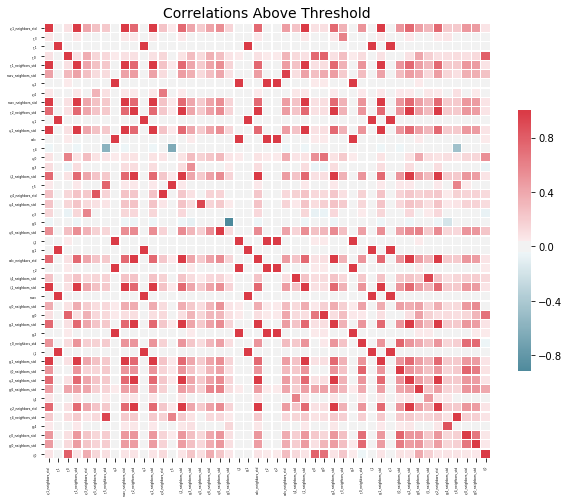

In [19]:
fs.plot_collinear()

In [20]:
correlated_features = fs.ops['collinear']

In [21]:
correlated_features

['g_0',
 'r_0',
 'i_0',
 'z_0',
 'u_1',
 'g_1',
 'r_1',
 'i_1',
 'z_1',
 'u_2',
 'g_2',
 'r_2',
 'i_2',
 'z_2',
 'r_5',
 'g_0_neighbors_std',
 'r_0_neighbors_std',
 'i_0_neighbors_std',
 'z_0_neighbors_std',
 'rowc_neighbors_std',
 'colc_neighbors_std',
 'colv_neighbors_std',
 'u_1_neighbors_std',
 'g_1_neighbors_std',
 'r_1_neighbors_std',
 'i_1_neighbors_std',
 'z_1_neighbors_std',
 'u_2_neighbors_std',
 'g_2_neighbors_std',
 'r_2_neighbors_std',
 'i_2_neighbors_std',
 'z_2_neighbors_std',
 'g_3_neighbors_std',
 'r_3_neighbors_std',
 'z_3_neighbors_std',
 'g_4_neighbors_std',
 'r_4_neighbors_std',
 'i_4_neighbors_std',
 'z_4_neighbors_std',
 'u_5_neighbors_std',
 'g_5_neighbors_std',
 'r_5_neighbors_std',
 'i_5_neighbors_std',
 'z_5_neighbors_std',
 'u_6_neighbors_std',
 'g_6_neighbors_std',
 'z_6_neighbors_std']

In [22]:
fs.record_collinear

,drop_feature,corr_feature,corr_value
0,g_0,u_0,0.691127
1,r_0,u_0,0.603847
2,r_0,g_0,0.766755
3,i_0,u_0,0.532712
4,i_0,g_0,0.689438
5,i_0,r_0,0.784979
6,z_0,u_0,0.524949
7,z_0,g_0,0.665781
8,z_0,r_0,0.740470
9,z_0,i_0,0.760788


In [23]:
fs.identify_zero_importance(task='classification', eval_metric='multi_logloss',
                            n_iterations=1, early_stopping=True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[383]	valid_0's multi_logloss: 0.394254

0 features with zero importance after one-hot encoding.



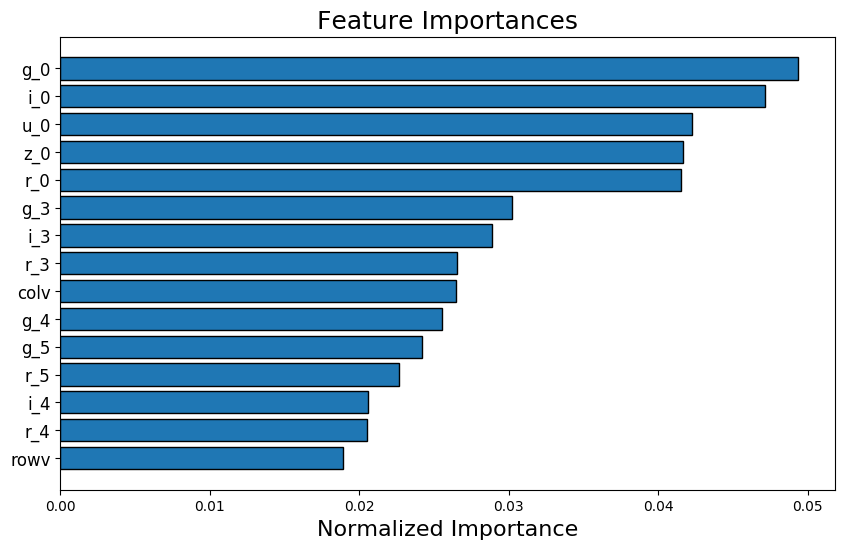

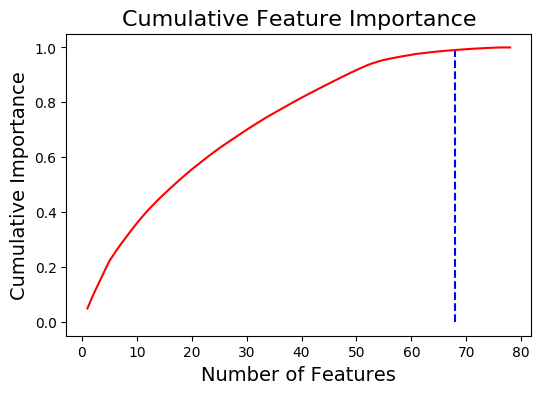

68 features required for 0.99 of cumulative importance


In [24]:
fs.plot_feature_importances(threshold = 0.99)

In [25]:
fs.identify_low_importance(cumulative_importance = 0.99)

67 features required for cumulative importance of 0.99 after one hot encoding.
11 features do not contribute to cumulative importance of 0.99.



In [26]:
low_importance_features = fs.ops['low_importance']

In [27]:
low_importance_features

['z_1',
 'i_2_neighbors_std',
 'i_1',
 'z_2',
 'r_2',
 'z_1_neighbors_std',
 'i_1_neighbors_std',
 'z_2_neighbors_std',
 'r_1',
 'r_2_neighbors_std',
 'r_1_neighbors_std']

In [28]:
fs.feature_importances

,feature,importance,normalized_importance,cumulative_importance
0,g_0,1702.0,0.049376,0.049376
1,i_0,1626.0,0.047171,0.096548
2,u_0,1456.0,0.042240,0.138787
3,z_0,1437.0,0.041688,0.180476
4,r_0,1431.0,0.041514,0.221990
5,g_3,1041.0,0.030200,0.252190
6,i_3,995.0,0.028866,0.281056
7,r_3,914.0,0.026516,0.307572
8,colv,912.0,0.026458,0.334030
9,g_4,881.0,0.025558,0.359588


In [29]:
fs.record_low_importance

,feature,importance,normalized_importance,cumulative_importance
67,z_1,56.0,0.001625,0.990717
68,i_2_neighbors_std,52.0,0.001509,0.992225
69,i_1,50.0,0.001451,0.993676
70,z_2,44.0,0.001276,0.994952
71,r_2,43.0,0.001247,0.996200
72,z_1_neighbors_std,37.0,0.001073,0.997273
73,i_1_neighbors_std,33.0,0.000957,0.998230
74,z_2_neighbors_std,29.0,0.000841,0.999072
75,r_1,29.0,0.000841,0.999913
76,r_2_neighbors_std,2.0,0.000058,0.999971


In [251]:
model = XGBClassifier(learning_rate=0.1, n_estimators=193, max_depth=18, gamma=4,
                      subsample=0.8, colsample_bytree=0.8, objective='multi:softmax',
                      num_class=3, nthread=-1, scale_pos_weight=1, seed=42, verbosity=1)

In [252]:
#cross_val_score(model, train, train_labels, cv=3, scoring='f1_macro')

In [253]:
model.fit(train, train_labels, eval_set=[(train, train_labels), (val, val_labels)],
          eval_metric='mlogloss')

[0]	validation_0-mlogloss:1.00045	validation_1-mlogloss:1.0073
[1]	validation_0-mlogloss:0.917063	validation_1-mlogloss:0.929154
[2]	validation_0-mlogloss:0.848343	validation_1-mlogloss:0.865353
[3]	validation_0-mlogloss:0.788443	validation_1-mlogloss:0.807572
[4]	validation_0-mlogloss:0.734149	validation_1-mlogloss:0.758107
[5]	validation_0-mlogloss:0.686521	validation_1-mlogloss:0.715193
[6]	validation_0-mlogloss:0.64608	validation_1-mlogloss:0.678486
[7]	validation_0-mlogloss:0.610119	validation_1-mlogloss:0.644866
[8]	validation_0-mlogloss:0.577938	validation_1-mlogloss:0.616124
[9]	validation_0-mlogloss:0.551546	validation_1-mlogloss:0.591503
[10]	validation_0-mlogloss:0.525435	validation_1-mlogloss:0.569285
[11]	validation_0-mlogloss:0.501798	validation_1-mlogloss:0.54952
[12]	validation_0-mlogloss:0.480982	validation_1-mlogloss:0.53175
[13]	validation_0-mlogloss:0.46213	validation_1-mlogloss:0.515634
[14]	validation_0-mlogloss:0.445351	validation_1-mlogloss:0.501567
[15]	validat

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=4,
       learning_rate=0.1, max_delta_step=0, max_depth=18,
       min_child_weight=1, missing=None, n_estimators=193, n_jobs=1,
       nthread=-1, num_class=3, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=None,
       subsample=0.8, verbosity=1)

In [254]:
result = model.evals_result_

In [255]:
epochs = len(result['validation_0']['mlogloss'])

In [256]:
x_axis = range(0, epochs)

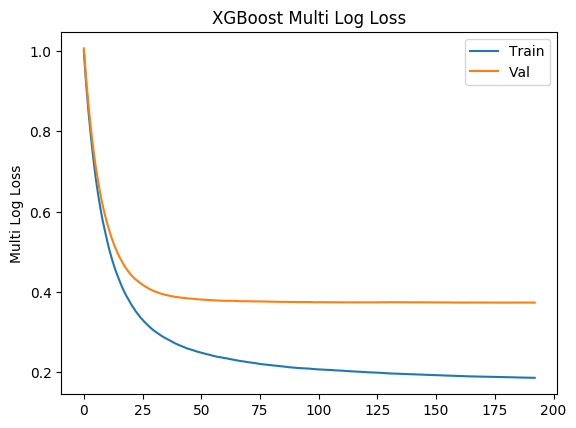

In [257]:
fig, ax = plt.subplots()
ax.plot(x_axis, result['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, result['validation_1']['mlogloss'], label='Val')
ax.legend()
plt.ylabel('Multi Log Loss')
plt.title('XGBoost Multi Log Loss')
plt.show()

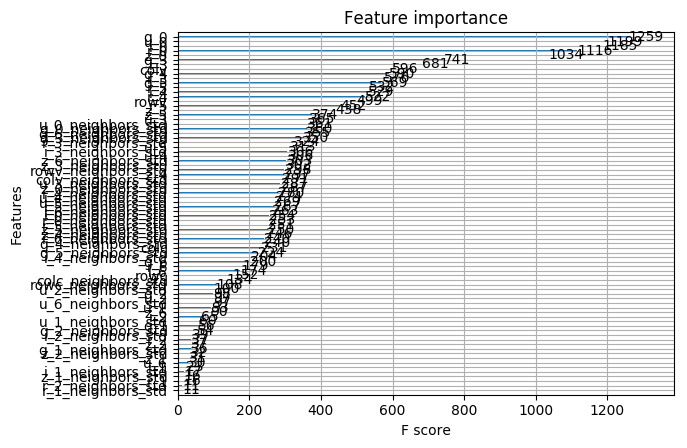

In [258]:
plot_importance(model)

In [259]:
pred = model.predict(val)

In [260]:
f1_score(val_labels, pred, average='macro')

0.8387624594264133

In [261]:
print(classification_report(val_labels, pred, labels=[0, 1, 2]))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92     13333
           1       0.78      0.70      0.74      5000
           2       0.83      0.89      0.86      5000

   micro avg       0.87      0.87      0.87     23333
   macro avg       0.84      0.84      0.84     23333
weighted avg       0.87      0.87      0.87     23333



### Model testing (use this code for other data testing)

Read your test dataframe

In [262]:
# test = pd.read_csv('test.csv', na_values='na')

Get test labels

In [42]:
# test_labels = test['class']

Fill dataframe na

In [43]:
# test.fillna(test.median(), inplace=True)

In [44]:
# test.drop(columns=to_remove, inplace=True)
# test.drop(columns=['class'], inplace=True)

Add features from nearest neighbors

In [45]:
# add_features(knn_model, scaler, orig_cols, train_with_unlabeled, test)

In [46]:
# pred = model.predict(test)

In [47]:
# f1_score(test_labels, pred, average='macro')

In [48]:
# print(classification_report(test_labels, pred, labels=[0, 1, 2]))